# Task 1: Migrating the data to BigQuery

Your task is to not only migrate the data to BigQuery, but also to modify the schema so it is easy for analysts to query. You could simply run an import with the schema auto-detection flag enabled. While this would work, it would be difficult for most analysts to query the nested fields using SQL.

**Step 1**
Use the initial schema as a starting point. 

**Step 2**
Redesign the data to be better optimized for a BigQuery data warehouse. Draw a diagram of your planned schema changes.

**Step 3**
Write a program to migrate the data into BigQuery. You can do this using Bash, Python, Java, or Dataform, but you need to write a program so it could be run repeatedly. You can use the BigQuery console to help, but the final results need to be code. Create a Dataflow Workbench instance and write the code in Jupyter Notebooks if you like.

**Step 4**
Using Looker Studio, create a dashboard that contains the following information:

Visits by Page
Most Popular Items
Sales by Category
Visit by Device Type


## Step 1

* Use the initial schema as a starting point. 

The following schema was automatically generated by Bigquery ingesting data from the JSON files 

In [ ]:
CREATE TABLE `jellyfish-training-demo-6.dsl_project.visits-default`
(
    events ARRAY<
        STRUCT<
            event STRUCT<
                details STRUCT<
                    items ARRAY<
                        STRUCT<
                            quantity INT64,
                            price FLOAT64,
                            category STRING,
                            product_name STRING,
                            product_id STRING
                        >
                    >,
                    currency STRING,
                    amount FLOAT64,
                    quantity INT64,
                    price FLOAT64,
                    category STRING,
                    page_url STRING,
                    referrer_url STRING,
                    product_name STRING,
                    order_id STRING,
                    product_id STRING
                >,
                timestamp TIMESTAMP,
                event_type STRING
            >
        >
    >,
    user_agent STRING,
    user_id STRING,
    geolocation STRING,
    device_type STRING,
    session_id STRING
);

### Issues with visits-default


**Redundant and Ambiguous Fields within event.details:**
Notice quantity, price, category, product_name, and product_id appear directly under event.details and again within the items array.

**This creates ambiguity:** Does event.details.quantity represent a total quantity for the event, or is it intended to be a single item's quantity? If an event has multiple items, these top-level fields are problematic. They either represent the first item's details (bad design), a summary (but then items array is redundant), or are simply confusing.
For analytics, this ambiguity makes querying complex and prone to errors. If you want to sum all quantities purchased, you'd have to be very careful not to double-count or miss data.

**Less Granular Event Details:**
The event.details struct holds a mix of general event attributes (page_url, referrer_url, currency, amount) and potential product-related fields outside the items array.
This structure makes it harder to understand the context of each event without drilling deep into the items array.

--- 
## Step 2

Redesign the data to be better optimized for a BigQuery data warehouse. Draw a diagram of your planned schema changes.

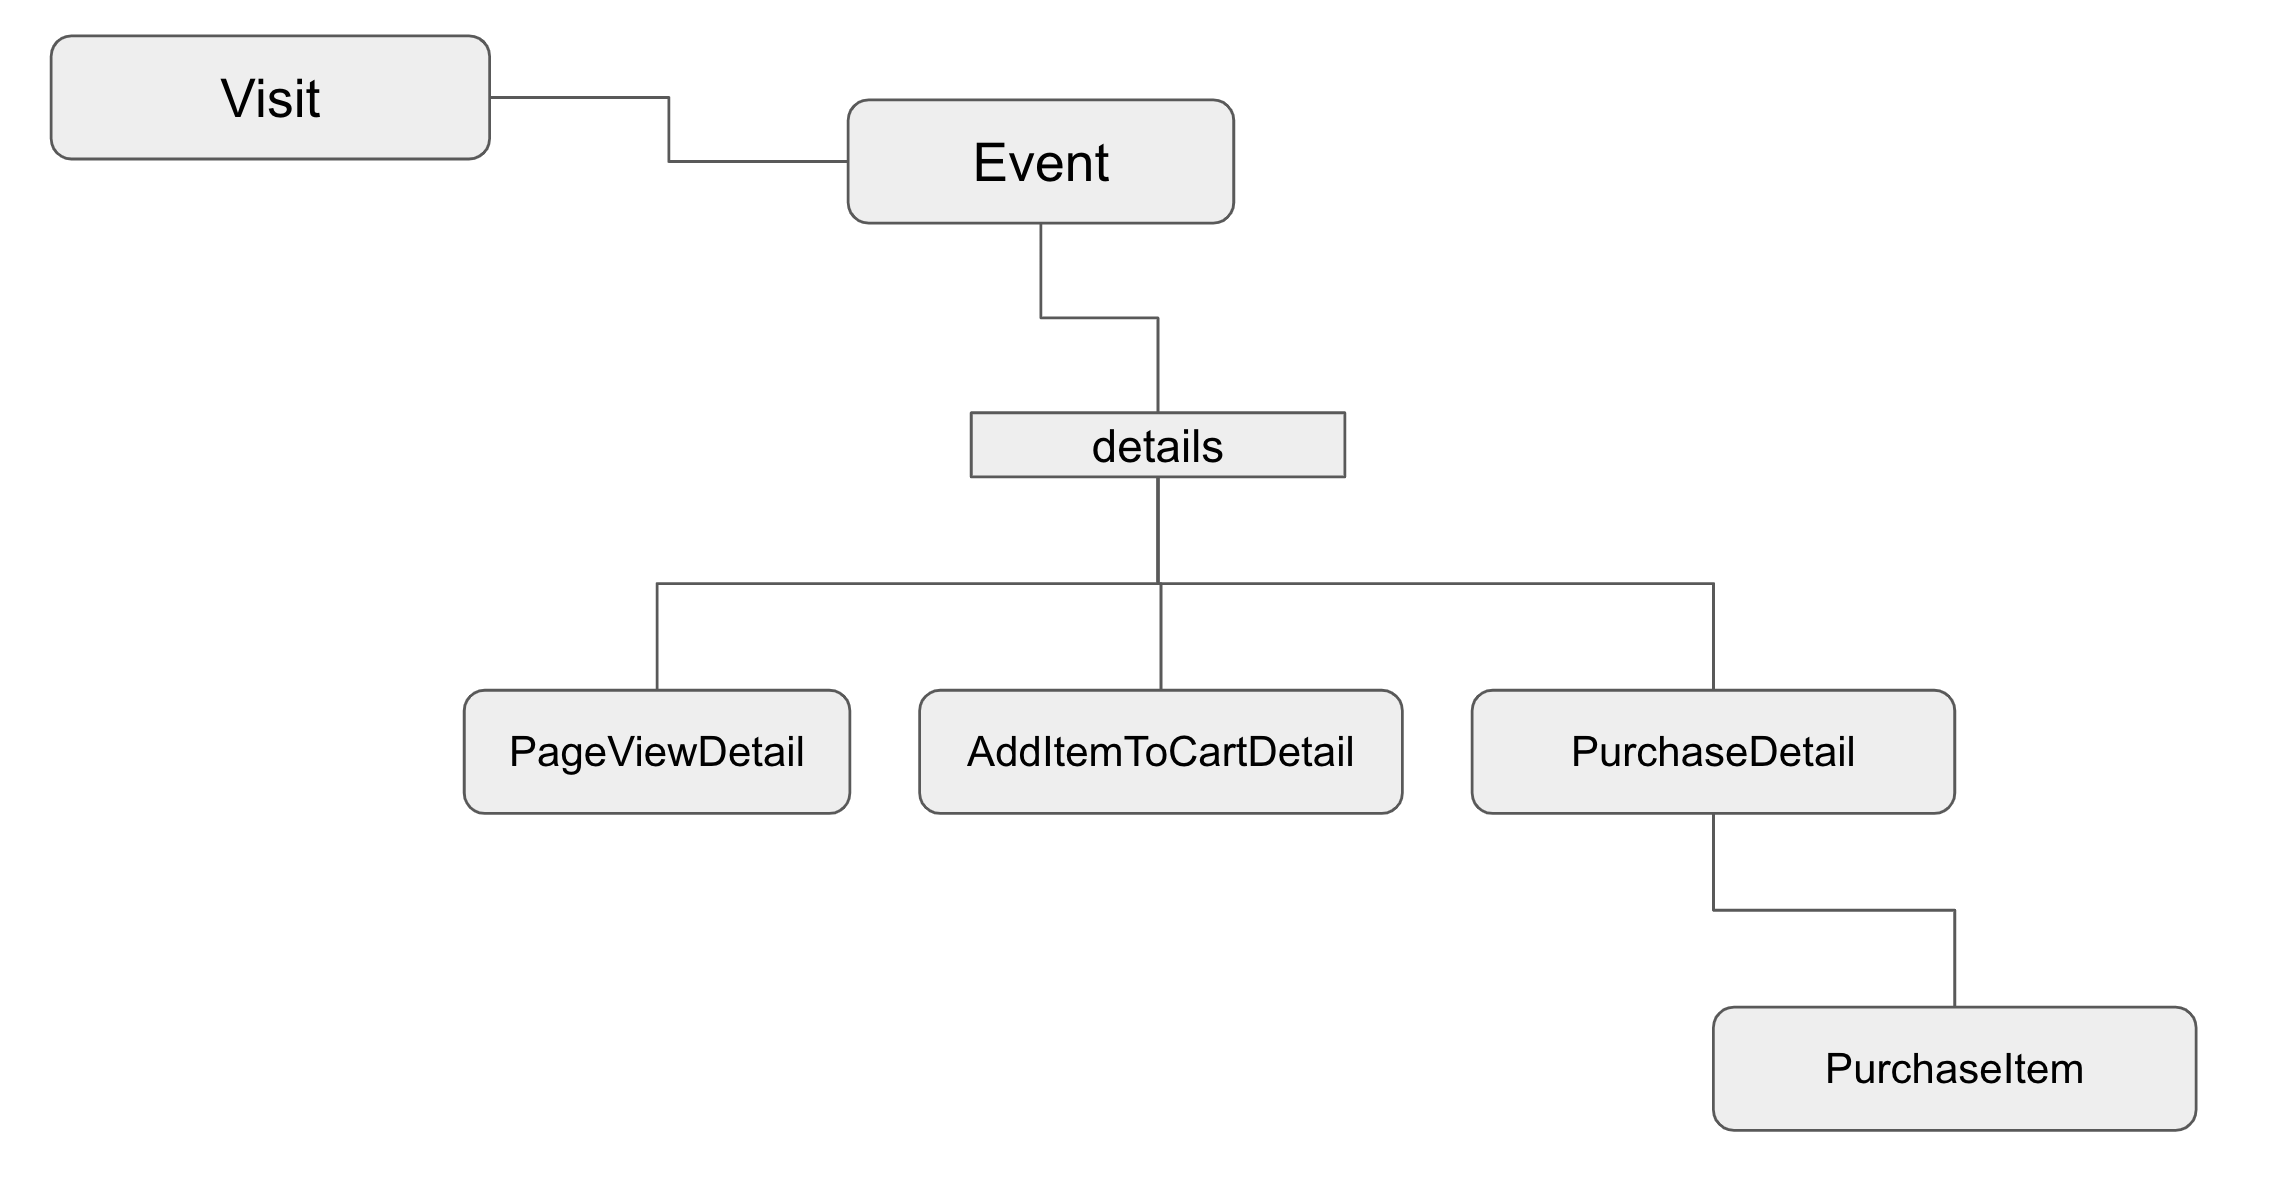


In [ ]:
# Schema redesign 

CREATE TABLE IF NOT EXISTS `jellyfish-training-demo-6.dsl_project.web_visits`
(
  session_id STRING,
  user_id STRING,
  device_type STRING,
  geolocation GEOGRAPHY,
  user_agent STRING,
  visit_start_time TIMESTAMP,
  visit_end_time TIMESTAMP,
  events ARRAY<STRUCT<
    event_type STRING,
    event_timestamp TIMESTAMP,
    -- PageView
    page_view STRUCT<
      page_url STRING,
      referrer_url STRING
    >,
    -- AddItemToCart
    add_cart STRUCT<
        product_id STRING,
        product_name STRING,
        category STRING,
        price FLOAT64,
        quantity INT64
    >,
    --PurchaseDetails
    purchase STRUCT<
        order_id STRING,
        amount FLOAT64,
        currency STRING,
        items ARRAY<STRUCT<
            product_id STRING,
            product_name STRING,
            category STRING,
            price FLOAT64,
            quantity INT64
        >>
    >
  >>
)
PARTITION BY DATE(visit_start_time)
CLUSTER BY device_type, user_id;



### Advantages of new schema  

**Clearer Separation of Concerns (Hierarchical Data Modeling)**

It places the items array within the details struct, and removes the redundant individual item-level fields (product_id, product_name, category, price, quantity) from the details struct itself.
This implies that page_url, referrer_url, order_id, amount, and currency are general event-level details, while the items array explicitly holds details for each individual product associated with that event (e.g., in a purchase event).


**Improved Query Performance and Simplicity**

Reduced Joins: In a traditional normalized database, an "events" table and an "items" table would require a join. In BigQuery, using nested and repeated fields (like events ARRAY of STRUCTs and items ARRAY of STRUCTs) denormalizes the data into a single, wide row. 

**Efficient Data Access**

When you query website_visits and need to analyze individual products, you use the UNNEST() function on the items array. This operation is highly optimized in BigQuery's columnar storage. You can easily get details for each item without complex joins.

**Less Ambiguity** 

Queries written against website_visits will be less ambiguous. If you want to sum item.price you know you are summing the price of each individual item, not some potentially ill-defined event-level price.

---
* Step 3

Write a program to migrate the data into BigQuery. You can do this using Bash, Python, Java, or Dataform, but you need to write a program so it could be run repeatedly. You can use the BigQuery console to help, but the final results need to be code. Create a Dataflow Workbench instance and write the code in Jupyter Notebooks if you like.

Check the notebook
insert_visits_to_BQ.jpynb


---
## Step 4

Using Looker Studio, create a dashboard that contains the following information:

* Visits by Page
* Most Popular Items
* Sales by Category
* Visit by Device Type

First, create some Materialized Views in BQ to meet the requirements 


In [ ]:

# create MV for Visits by Device Type

CREATE MATERIALIZED VIEW IF NOT EXISTS `dsl_project.visits_by_device_type`
CLUSTER BY hourly_timestamp, device_type
OPTIONS (enable_refresh = false)
AS
SELECT
    TIMESTAMP_TRUNC(visit_start_time, HOUR) AS hourly_timestamp,
    device_type,
    COUNT(session_id) AS visit_count
  FROM `dsl_project.web_visits`
  GROUP BY 1, 2;


In [ ]:


# view for Most Popular Items

CREATE MATERIALIZED VIEW IF NOT EXISTS `dsl_project.mv_most_purchased_items_hourly`
CLUSTER BY hourly_timestamp, category, product_name
OPTIONS (enable_refresh = false) --Cost savings for demo project
AS
SELECT
    TIMESTAMP_TRUNC(events.event_timestamp, HOUR) AS hourly_timestamp,
    purchase_items.product_id AS product_id,
    purchase_items.product_name AS product_name,
    purchase_items.category AS category,
    SUM(purchase_items.quantity) AS total_quantity_purchased,
    COUNT(events.purchase.order_id) AS number_of_orders
  FROM
    `dsl_project.web_visits`,
    UNNEST(events) AS events,
    UNNEST(events.purchase.items) AS purchase_items
  WHERE events.event_type = 'purchase'
  GROUP BY 1, 2, 3, 4;

In [ ]:
# view for Sales by Category 

CREATE MATERIALIZED VIEW IF NOT EXISTS `dsl_project.mv_sales_per_category_hourly`
CLUSTER BY hourly_timestamp, category
OPTIONS (enable_refresh = false) --Cost savings for demo project
AS
SELECT
    TIMESTAMP_TRUNC(events.event_timestamp, HOUR) AS hourly_timestamp,
    purchase_items.category AS category,
    SUM(purchase_items.price * purchase_items.quantity) AS total_sales,
    COUNT(events.purchase.order_id) AS number_of_orders
  FROM
    `dsl_project.web_visits`,
    UNNEST(events) AS events,
    UNNEST(events.purchase.items) AS purchase_items
  WHERE events.event_type = 'purchase'
  GROUP BY 1, 2;

In [ ]:
# view Page Views per hour 

CREATE MATERIALIZED VIEW IF NOT EXISTS `dsl_project.mv_page_views_hourly`
CLUSTER BY hourly_timestamp, page_url
OPTIONS (enable_refresh = false) --Cost savings for demo project
AS
SELECT
  TIMESTAMP_TRUNC(events.event_timestamp, HOUR) AS hourly_timestamp,
  events.page_view.page_url AS page_url,
  COUNT(*) AS page_view_count
FROM
  `dsl_project.web_visits` v,
  UNNEST(events) AS events
WHERE events.event_type = 'page_view'
GROUP BY 1, 2;



Looker Studio Report
https://lookerstudio.google.com/s/lydcAEww9L0
